# GBM comparison
Author: [Ryan Parker](https://github.com/rparkr)

A comparison of different gradient boosting machine (GBM) models on a classification task. Models compared include:
- scikit-learn: [sklearn.ensemble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)
- XGBoost: [xgoost.XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)
- LightGBM: [lightgbm.LGBMClassifier](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier)
- CatBoost: [catboost.CatBoostClassifier](https://catboost.ai/en/docs/concepts/python-quickstart)

Dataset: [University of California at Irvine (UCI), Credit Approval](https://archive-beta.ics.uci.edu/dataset/27/credit+approval)
- 15 features
- binary target
- mix of categorical (nominal), boolean, and continuous variables
- for confidentiality, features were mapped to meaningless symbols, making the dataset interesting because it is not directly interpretable


# Data: load and explore
The dataset for this comparison is [UCI Credit Approval](http://archive.ics.uci.edu/dataset/27/credit+approval), a small dataset with 690 samples, 15 features, and a binary target: approved vs. declined. The dataset's features have meaningless names and categorical values have been replaced for anonyminity, making it a useful dataset to explore without biases from heuristics or expectations of a variable's impact on the target.

The data can be obtained from the [University of California and Irvine (UCI)](http://archive.ics.uci.edu/dataset/27/credit+approval), or from [OpenML.org](https://openml.org/search?type=data&status=active&id=29). For convenience, I'll load it from OpenML.org since scikit-learn has a method to load data from OpenML directly to a `pandas` `DataFrame`.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml  # download the UCI credit approval dataset from OpenML.org

pd.options.display.precision = 3  # set decimal precision for DataFrame display

In [2]:
# Dataset source: https://openml.org/search?type=data&status=active&id=29
X, y = fetch_openml(data_id=29, parser='auto', as_frame=True, return_X_y=True)



# Alternatively:
# df = pd.read_csv(
#     filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data',
#     header=0,
#     names=[f"x{i}" for i in range(15)] + ['y'],
#     index_col=False
# )

# Missing values are denoted with '?'
# df = df.replace('?', np.nan)
# catg_columns = df.select_dtypes(include='object').columns
# df[catg_columns] = df[catg_columns].astype('category')

# X = df[[f"x{i}" for i in range(15)]]
# y = df['y']

In [3]:
X.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0


In [4]:
# Check the distribution of the target variable
y.value_counts(normalize=True)

-    0.555
+    0.445
Name: class, dtype: float64

In [5]:
# Encode y in binary form
y = y.replace(to_replace={'+': 1, '-': 0})

# Or, encode as Boolean using:
# y = (y == '+')

y.value_counts(normalize=True)

0    0.555
1    0.445
Name: class, dtype: float64

In [6]:
X.describe()  # summarize the numerical variables

,A2,A3,A8,A11,A14,A15
count,678.000,690.000,690.000,690.000,677.000,690.000
mean,31.568,4.759,2.223,2.400,184.015,1017.386
std,11.958,4.978,3.347,4.863,173.807,5210.103
min,13.750,0.000,0.000,0.000,0.000,0.000
25%,22.602,1.000,0.165,0.000,75.000,0.000
50%,28.460,2.750,1.000,0.000,160.000,5.000
75%,38.230,7.207,2.625,3.000,276.000,395.500
max,80.250,28.000,28.500,67.000,2000.000,100000.000


In [7]:
# Check for missing values, and check the data types
# of each column in the DataFrame to confirm that the
# features with categorical values are encoded as the
# 'category' dtype, which assists the GBMs in identifying
# and handling them properly.
pd.concat([
    X.dtypes.to_frame(name='dtype'),
    (X.isna().sum() / len(X.index)).to_frame(name='pct_missing_vals')
], axis=1).style.format({'pct_missing_vals': "{:,.1%}"})

# Alternatively:
# X.info()

,dtype,pct_missing_vals
A1,category,1.7%
A2,float64,1.7%
A3,float64,0.0%
A4,category,0.9%
A5,category,0.9%
A6,category,1.3%
A7,category,1.3%
A8,float64,0.0%
A9,category,0.0%
A10,category,0.0%


In [8]:
# The target (label) has no missing data:
y.isna().sum() / len(y)

0.0

## Check cardinality of categorical features

In [9]:
# Check the cardinality for each categorical feature
print('Number of unique values for each categorical feature:')
X.select_dtypes(include='category').apply(lambda x: len(x.value_counts()))

Number of unique values for each categorical feature:


A1      2
A4      3
A5      3
A6     14
A7      9
A9      2
A10     2
A12     2
A13     3
dtype: int64

In [10]:
# See how values are encoded
X['A5'].to_frame(name='A5').assign(cat_codes = X['A5'].cat.codes).value_counts()

A5  cat_codes
g   0            519
p   2            163
gg  1              2
dtype: int64

## Visualize the dataset

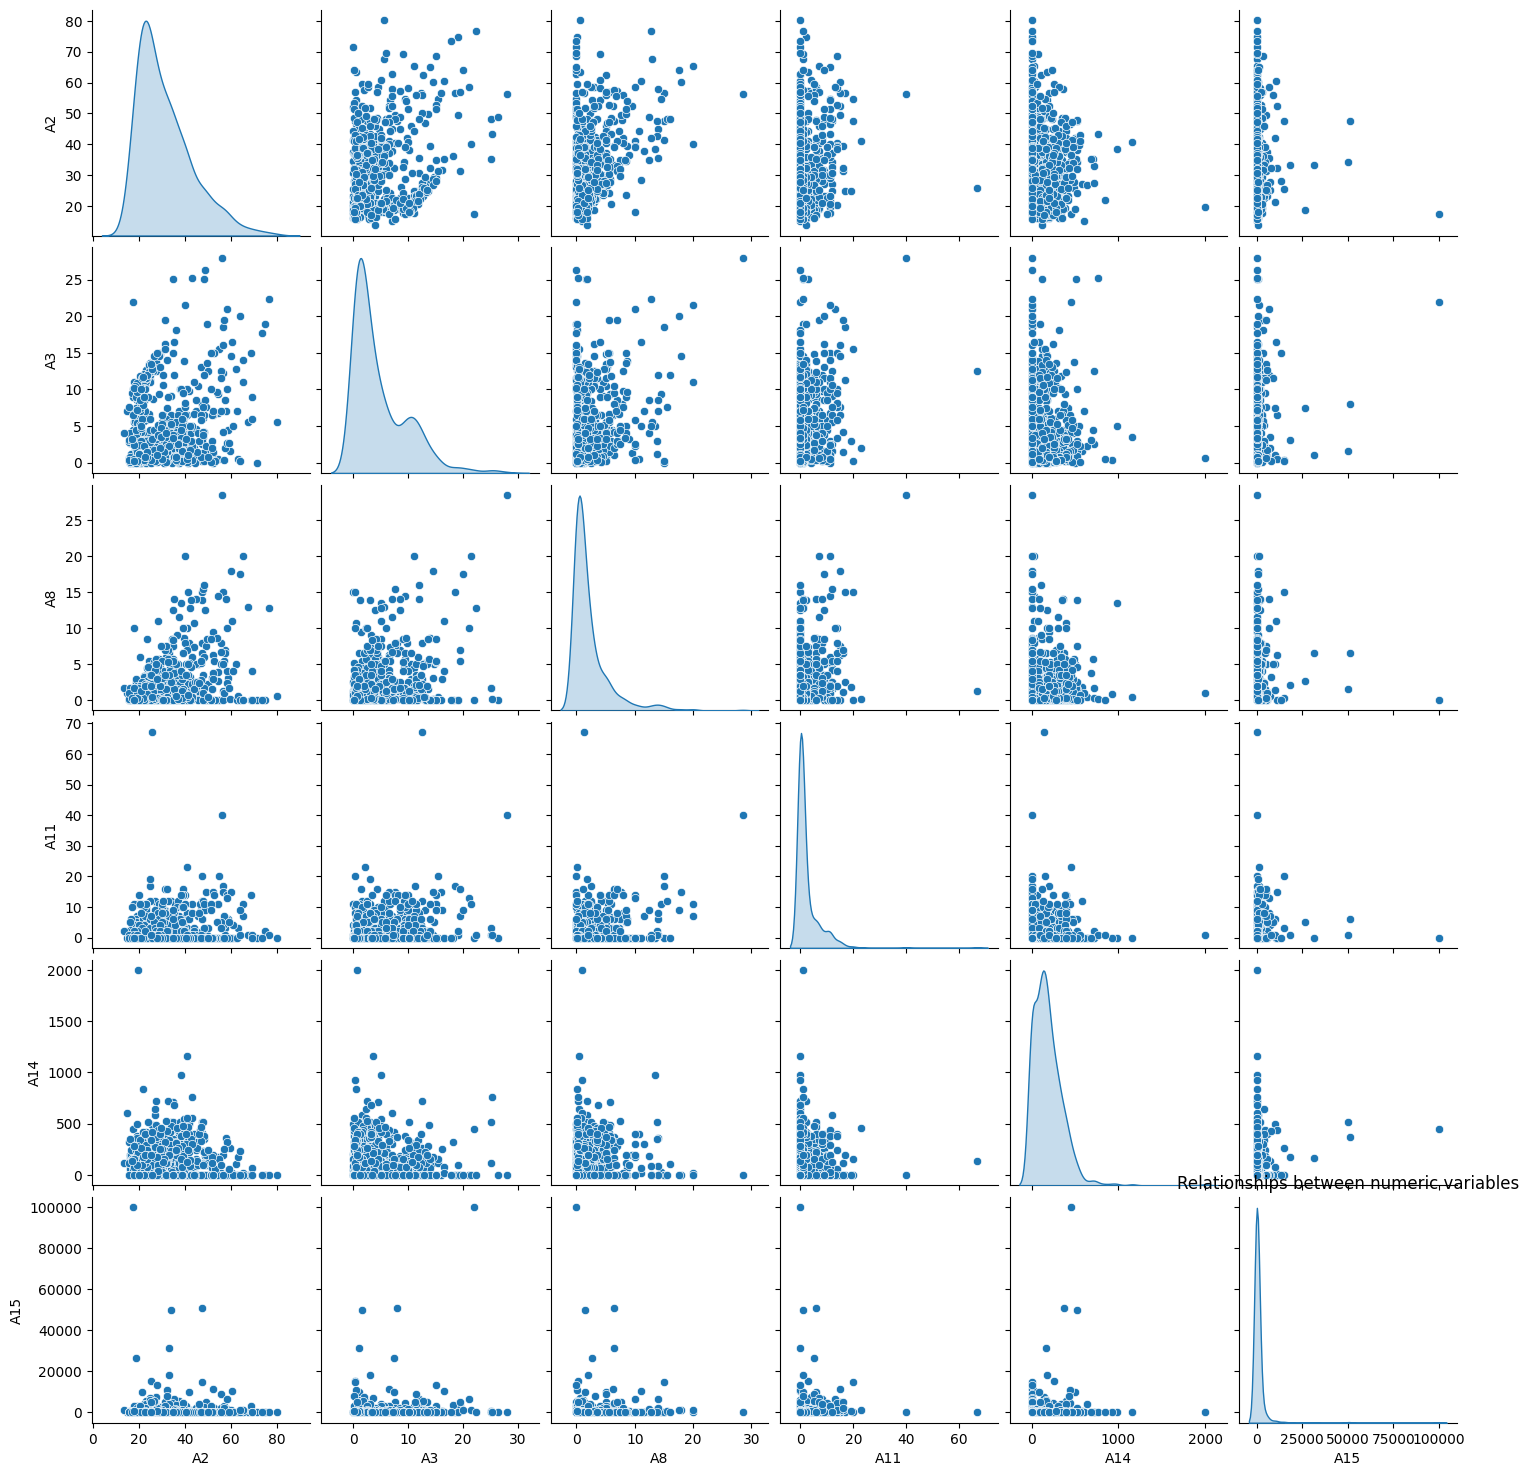

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data=X.select_dtypes(include='number'), diag_kind='kde')
plt.title('Relationships between numeric variables')
plt.tight_layout()
plt.show()

## Feature distributions

According to the [dataset's documentation](https://archive-beta.ics.uci.edu/dataset/27/credit+approval), the values are:

| column | values                                        |
|--------|-----------------------------------------------|
| A1     |  b, a                                         |
| A2     |  continuous                                   |
| A3     |  continuous                                   |
| A4     |  u, y, l, t                                   |
| A5     |  g, p, gg                                     |
| A6     |  c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff  |
| A7     |  v, h, bb, j, n, z, dd, ff, o                 |
| A8     |  continuous                                   |
| A9     |  t, f                                         |
| A10    |  t, f                                         |
| A11    |  continuous                                   |
| A12    |  t, f                                         |
| A13    |  g, p, s                                      |
| A14    |  continuous                                   |
| A15    |  continuous                                   |


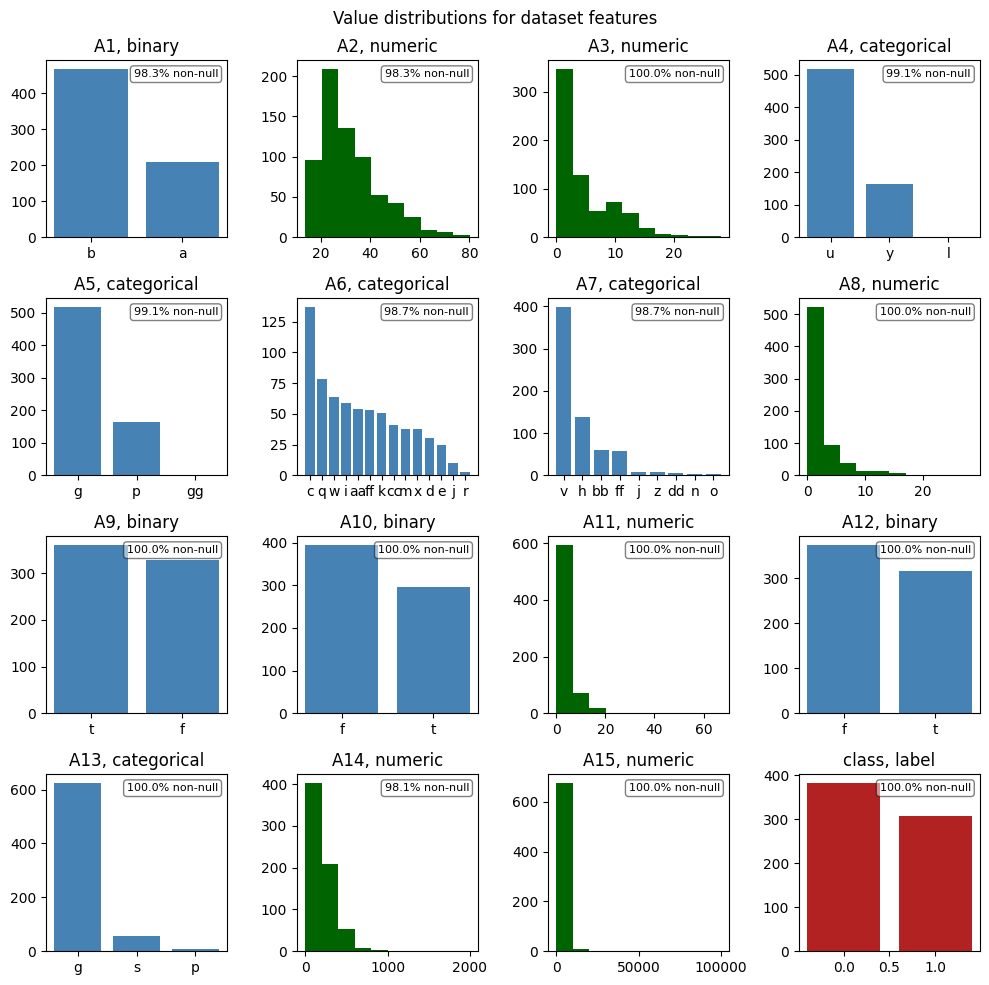

In [12]:
df = pd.concat([X, y], axis=1)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), dpi=100)
for n, ax in enumerate(axs.flatten()):
    col = df.columns[n]
    x_vals, y_vals = df[col].value_counts().index, df[col].value_counts().values
    col_type = (
        'label' if n == 15
        else 'binary' if pd.api.types.is_categorical_dtype(df[col]) and len(x_vals) == 2
        else 'categorical' if pd.api.types.is_categorical_dtype(df[col])
        else 'numeric'
    )
    color = (
        'firebrick' if n == 15  # target, or label
        else 'darkgreen' if col_type == 'numeric'
        else 'steelblue'
    )
    if col_type == 'numeric':
        ax.hist(df[col].values, color=color)
    else:
        ax.bar(x_vals, y_vals, color=color)

    ax.set_title(f"{col}, {col_type}")
    # Count null values and place in a textbox.
    # see: https://matplotlib.org/stable/gallery/text_labels_and_annotations/placing_text_boxes.html
    non_null_pct = 1 - (df[col].isna().sum() / len(df.index))
    textstr = f"{non_null_pct:.1%} non-null"
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    # place a text box in upper right in axes coords
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right', bbox=props)
fig.suptitle('Value distributions for dataset features')
plt.tight_layout()
plt.show()

We learn from the plots above that the dataset has null values, some very skewed variables, extreme outliers, and significant class imbalances. Fortunately, none of those are worrisome for decision tree-based models like gradient-boosting machines.

# Data prep
Encode the categories as integers using an `OrdinalEncoder` in a `Pipeline`.

Adapted from the scikit-learn tutorial on [Categorical Feature Support in Gradient Boosting](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html).

In [13]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

In [14]:
# List categorical features
catg_features = X.select_dtypes(include='category').columns
catg_features

Index(['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13'], dtype='object')

In [15]:
# List numerical features
numerical_features = X.select_dtypes(include='number').columns
numerical_features

Index(['A2', 'A3', 'A8', 'A11', 'A14', 'A15'], dtype='object')

In [16]:
# make_column_transformer applies transformations to columns,
# which are specified in tuples as: (transformer, columns)
ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan),  # transformation
        make_column_selector(dtype_include='category')   # columns to which transformation is applied
    ),
    remainder='passthrough',  # all numeric columns should be passed through
    verbose_feature_names_out=False  # keep original feature names
)

# Model comparison

## References

<details><summary>Click to expand</summary>

**Model scoring and cross-validation**  
- Scoring: [`sklearn.metrics`](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)... `.accuracy_score`, `.f1_score`, `.precision_score`, `.recall_score`, `.roc_auc_score` (area under the receiver operating characteristic curve)
- Cross-validation: [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

**scikit-learn: [`sklearn.ensemble.HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)**
- [User guide](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)
- [Categorical feature support in gradient boosting: example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html)
- [Native categorical feature support in `HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/ensemble.html#categorical-support-gbdt)

**XGBoost: [`xgboost.XGBClassifier`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)** (follows the scikit-learn API)  
- [XGBoost user guide: categorical data](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html)
- [Tree methods supported by XGBClassifier](https://xgboost.readthedocs.io/en/stable/treemethod.html): `'approx'`, `'hist'` (similar algorithm to LightGBM), `'gpu_hist'` (GPU version of `'hist'`)
- [XGBoost docs: XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

**LightGBM [`lightgbm.LGBMClassifier`](https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html):**
- [LightGBM quickstart](https://lightgbm.readthedocs.io/en/stable/Python-Intro.html)
- [Available parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html) for `LGBMClassifier`

**CatBoost [`catboost.CatBoostClassifier`](https://catboost.ai/en/docs/concepts/python-quickstart#classification):**  
- [Quick start guide](https://catboost.ai/en/docs/concepts/python-quickstart)
- [Full docs on `CatBoostClassifier`](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

</details>

## Import packages

In [17]:
%pip install --quiet xgboost lightgbm catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost

## Set up GBM pipelines

In [19]:
random_state = 12

# scikit-learn
gbm_sklearn = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingClassifier(
        categorical_features=catg_features,
        random_state=random_state)
).set_output(transform='pandas')  # return a pandas DataFrame when calling .transform()

# XGBoost
gbm_xgb = make_pipeline(
    ordinal_encoder,
    xgb.XGBClassifier(
        tree_method='hist',  # valid values are: 'approx', 'hist', and 'gpu_hist'. See: https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html and https://xgboost.readthedocs.io/en/stable/treemethod.html
        enable_categorical=True,
        random_state=random_state)
).set_output(transform='pandas')

# LightGBM
gbm_lgb = make_pipeline(
    ordinal_encoder,
    lgb.LGBMClassifier(
        # categorical_feature=catg_features,  # detects automatically
        random_state=random_state)
).set_output(transform='pandas')

# Catboost
gbm_cb = make_pipeline(
    ordinal_encoder,
    catboost.CatBoostClassifier(
        # cat_features=catg_features,  # detects automatically
        verbose=False,
        random_state=random_state)
).set_output(transform='pandas')


## Fit models
Train each GBM using 5-fold cross-validation and save the results for comparison.

In [20]:
import time  # measure model fit time

t0 = time.perf_counter()

# Create dictionaries of scoring results
sklearn_results = cross_validate(
    estimator=gbm_sklearn,
    X=X,
    y=y,
    scoring=('accuracy', 'f1', 'precision', 'recall', 'roc_auc')
)
print(f"sklearn: {time.perf_counter() - t0:,.2f}s")

t0 = time.perf_counter()
xgb_results = cross_validate(
    estimator=gbm_xgb,
    X=X,
    y=y,
    scoring=('accuracy', 'f1', 'precision', 'recall', 'roc_auc')
)
print(f"XGBoost: {time.perf_counter() - t0:,.2f}s")

t0 = time.perf_counter()
lgb_results = cross_validate(
    estimator=gbm_lgb,
    X=X,
    y=y,
    scoring=('accuracy', 'f1', 'precision', 'recall', 'roc_auc')
)
print(f"LightGBM: {time.perf_counter() - t0:,.2f}s")

t0 = time.perf_counter()
cb_results = cross_validate(
    estimator=gbm_cb,
    X=X,
    y=y,
    scoring=('accuracy', 'f1', 'precision', 'recall', 'roc_auc')
)
print(f"CatBoost: {time.perf_counter() - t0:,.2f}s")

sklearn: 15.77s
XGBoost: 6.53s
LightGBM: 9.19s
CatBoost: 28.65s


## Compare performance

In [21]:
print('Average across five cross-validation splits:')

pd.DataFrame.from_dict(
    dict(
        sklearn = sklearn_results,
        XGBoost = xgb_results,
        LightGBM = lgb_results,
        Catboost = cb_results
    )
).applymap(np.mean).T

# To see standard deviation as well, replace .applymap() above with:
# .applymap(lambda x: f"avg: {np.mean(x):,.3f}, std: {np.std(x):,.3f}")

Average across five cross-validation splits:


,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
sklearn,2.857,0.293,0.849,0.844,0.844,0.857,0.912
XGBoost,1.150,0.151,0.826,0.819,0.806,0.844,0.912
LightGBM,1.684,0.150,0.845,0.837,0.839,0.847,0.916
Catboost,5.639,0.087,0.852,0.849,0.843,0.873,0.926


Check results from all five cross-validation rounds for a single estimator:

In [22]:
df_sklearn = pd.DataFrame.from_dict(sklearn_results)
# Add rows with the mean and standard deviation
df_sklearn.loc['avg'] = df_sklearn.mean()
df_sklearn.loc['std'] = df_sklearn.loc[0:4, :].std()
df_sklearn

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc
0,2.377,0.098,0.659,0.689,0.584,0.839,0.787
1,1.937,0.101,0.949,0.942,0.966,0.919,0.983
2,2.546,0.735,0.920,0.906,0.946,0.869,0.969
3,0.986,0.401,0.812,0.797,0.761,0.836,0.854
4,6.440,0.132,0.906,0.885,0.962,0.820,0.969
avg,2.857,0.293,0.849,0.844,0.844,0.857,0.912
std,2.092,0.277,0.118,0.102,0.168,0.039,0.087


# Visualizations

## Feature importance
Use the `shap` package to show which features influence the models' outputs the most.

**References:**  
- [SHAP beeswarm plot](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html)
- [SHAP summary plot](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html)

In [23]:
%pip install --quiet shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 17.6 MB/s eta 0:00:00


In [24]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Transform the dataset (and sort columns to original order) to match the dataset that each model was trained on.

SHAP can't use `sklearn`'s `Pipeline` object, so we need to fit each model first and then use the fitted model and the transformed data with the `shap.Explainer` object.

In [25]:
X_transformed = ordinal_encoder.fit_transform(X)[X.columns]  # encode, then sort by indexing to the original column order

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
 97%|=================== | 666/690 [00:36<00:01]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


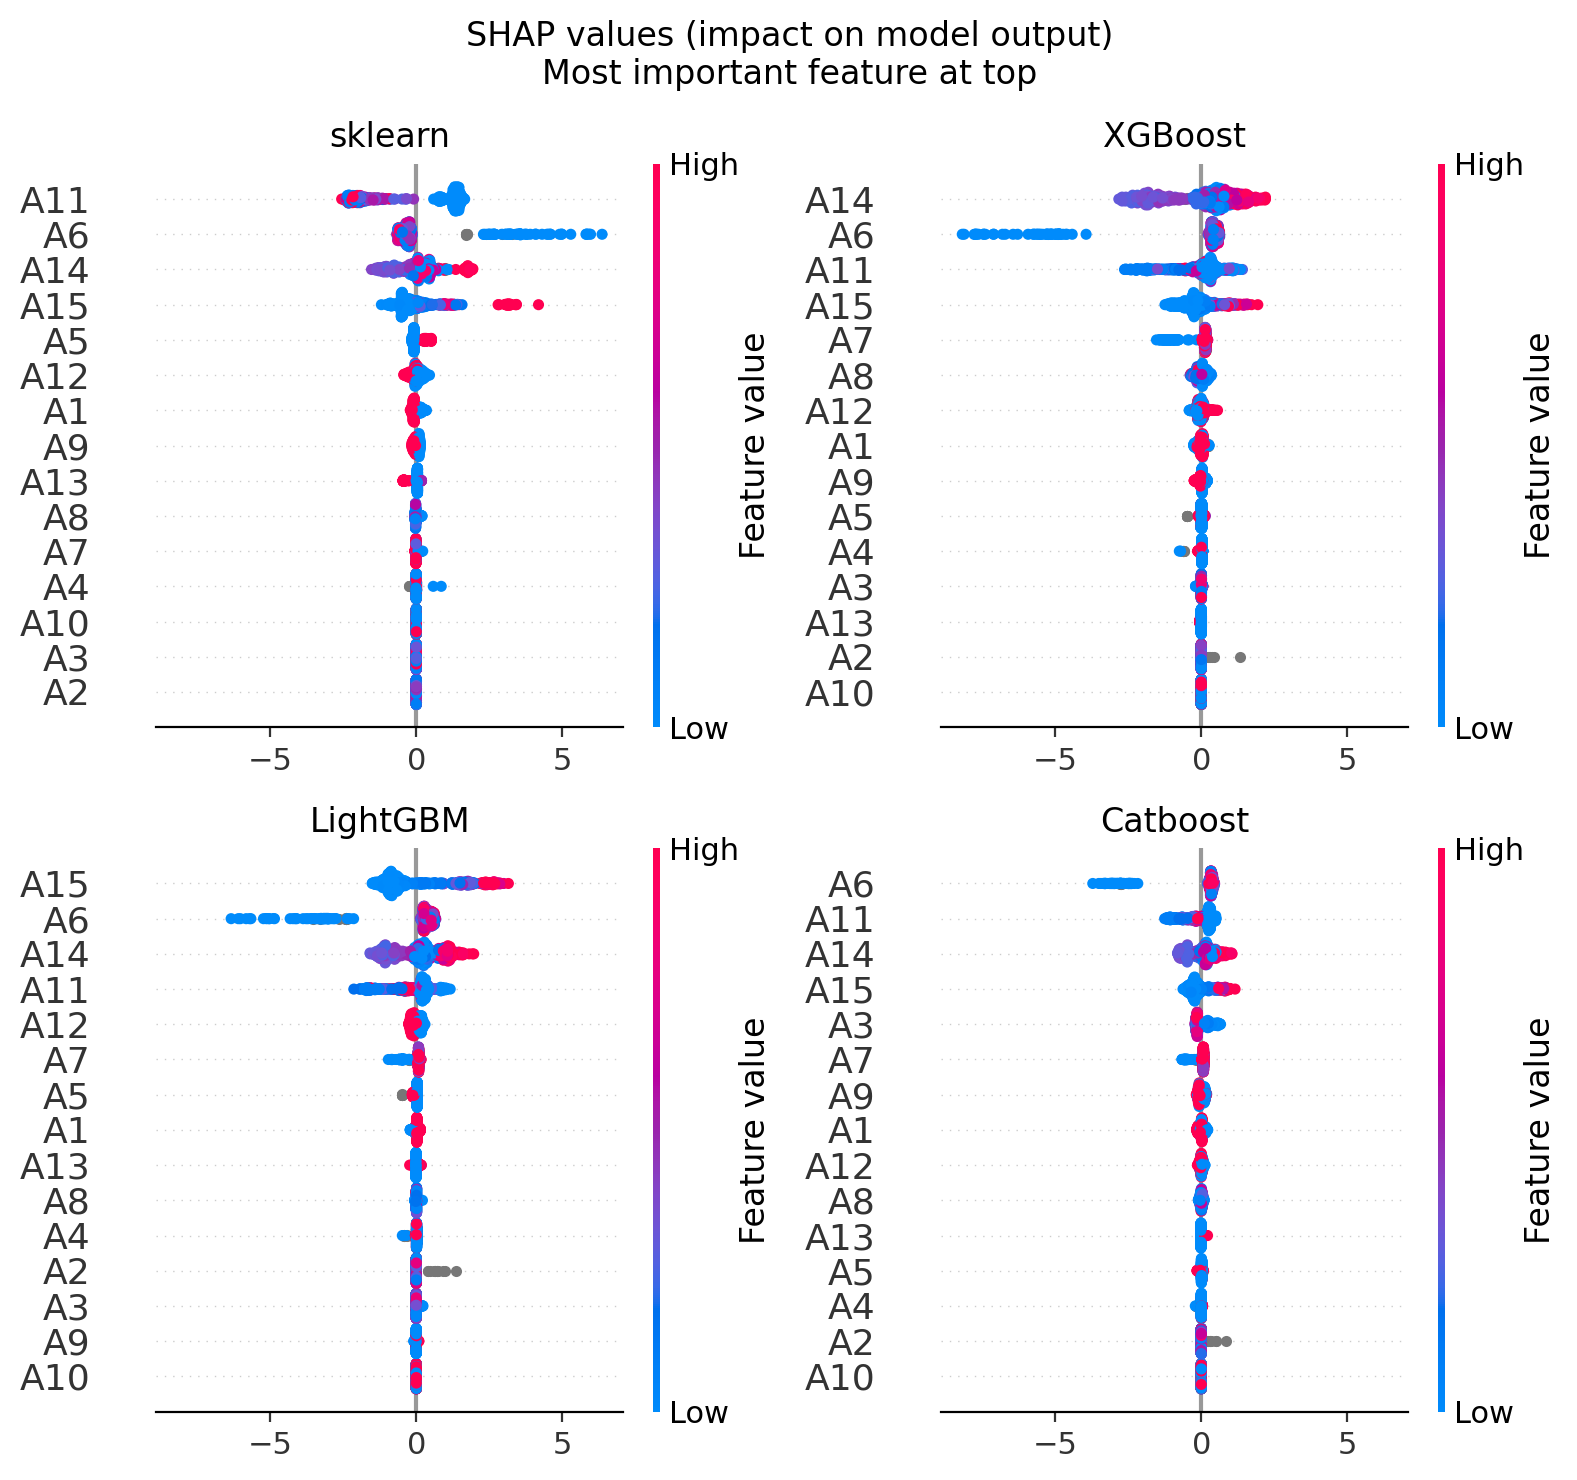

In [26]:
fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(8, 16),
    dpi=200,
    sharex=True  # set plots to same scale
)

for model, title, ax in zip(
        [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
        ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
        axs.flatten()):
    # Fit the model so it can be used by the SHAP explainer
    model.fit(X, y)

    # Compute SHAP values, indexing [-1] into the final part of the
    # pipeline, which contains the fitted model
    explainer = shap.Explainer(model[-1], X_transformed)
    shap_values = explainer(X_transformed)  # can also use a subset of the rows of X to compute the SHAP values
    # set the current axis for the plot. See: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.sca.html
    plt.sca(ax)
    shap.plots.beeswarm(shap_values, show=False, max_display=15)
    ax.set_xlabel('')  # overwrite the x label set by shap
    ax.set_title(title)

fig.suptitle('SHAP values (impact on model output)\nMost important feature at top')
plt.tight_layout()
plt.show()

<span style="font-size: 18px; font-weight: bold">How to read the SHAP beeswarm plot</span>

**Order**  
From the plot above, we learn which features influence the model's outputs the most: the features are sorted in descending order of impact, with the most important features at the top and the least important at the bottom.

**X-axis position (left or right)**  
The X axis shows the _SHAP value_ for each instance (_sample_, or row in the dataset) for each feature. A positive SHAP value means that the instance increased the model's output (towards the label of 1, in this binary classification case) and a negative SHAP value means that the instance decreased the model's output.

**Color**  
The color shows the value of the instance: blue represents a low value and red represents a high value (for that feature).

**Example**  
For the `sklearn` plot (top-left), the feature that influences the model's predictions the most is `A11`. When that feature is <span style="color: royalblue; font-weight: bold; font-style; italic;">low</span>, the model's output is _higher_; i.e., closer to 1, which means "credit approved" for this dataset.

### Feature importance for a single data point (row)

 97%|=================== | 667/690 [00:39<00:01]       

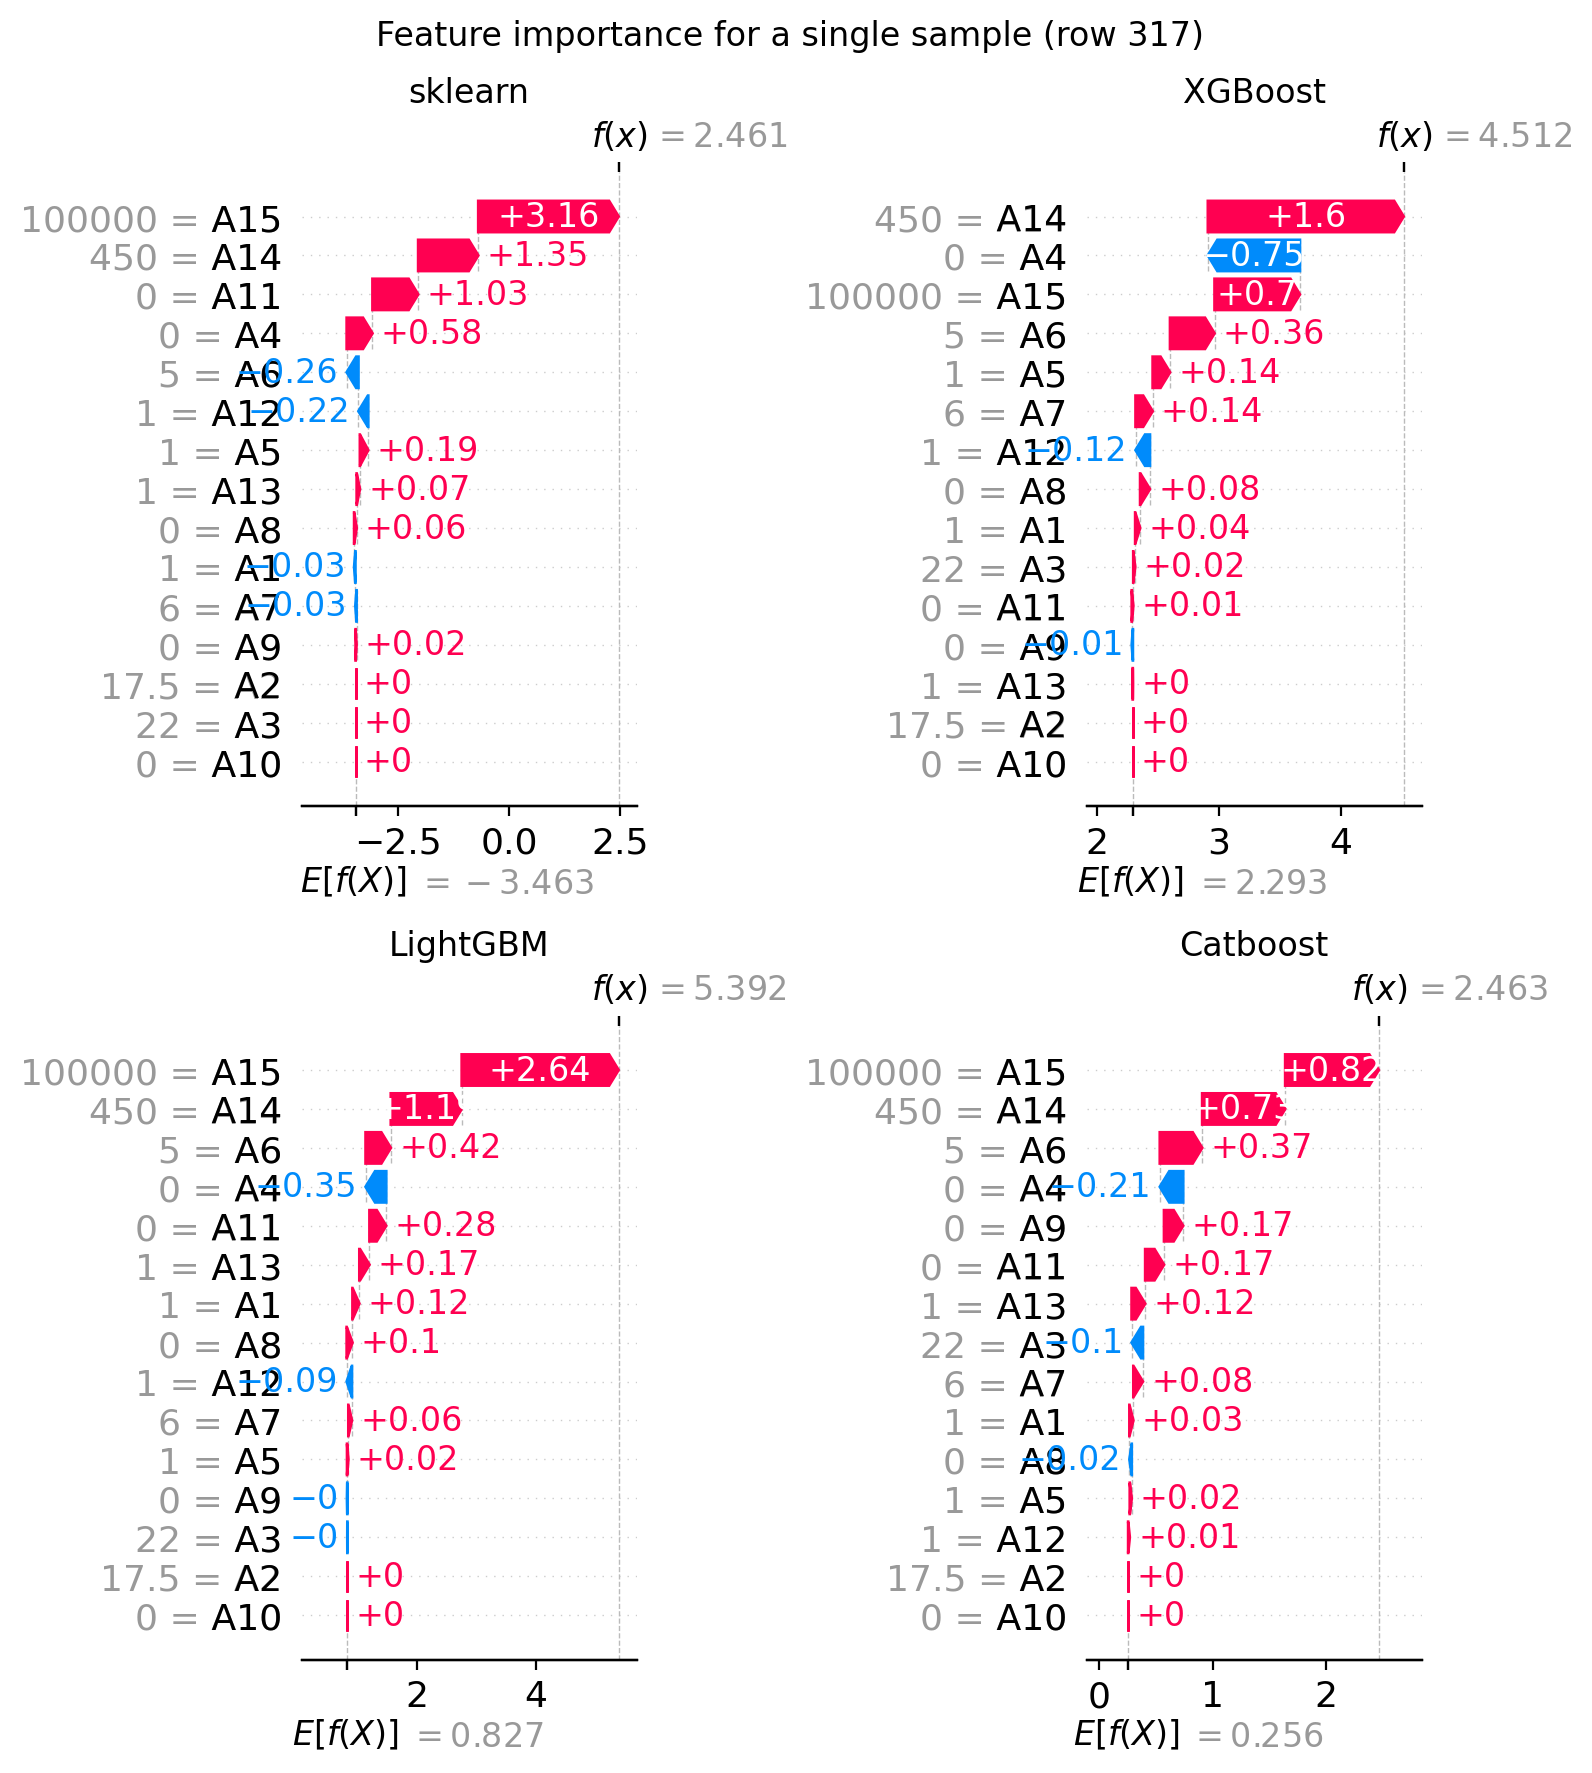

In [27]:
ROW_NUM = 317  # 0-689; the row index to use

fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(12, 16),
    dpi=200
)

for model, title, ax in zip(
        [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
        ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
        axs.flatten()):
    # Fit the model so it can be used by the SHAP explainer
    model.fit(X, y)

    # Compute SHAP values, indexing [-1] into the final part of the
    # pipeline, which contains the fitted model
    explainer = shap.Explainer(model[-1], X_transformed)
    shap_values = explainer(X_transformed)  # can also use a subset of the rows of X to compute the SHAP values
    # set the current axis for the plot. See: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.sca.html
    plt.sca(ax)
    shap.plots.waterfall(shap_values[ROW_NUM], show=False, max_display=15)
    ax.set_xlabel('')  # overwrite the x label set by shap
    ax.set_title(title)

fig.suptitle(f"Feature importance for a single sample (row {ROW_NUM})")
plt.tight_layout()
plt.show()


## Confusion matrix

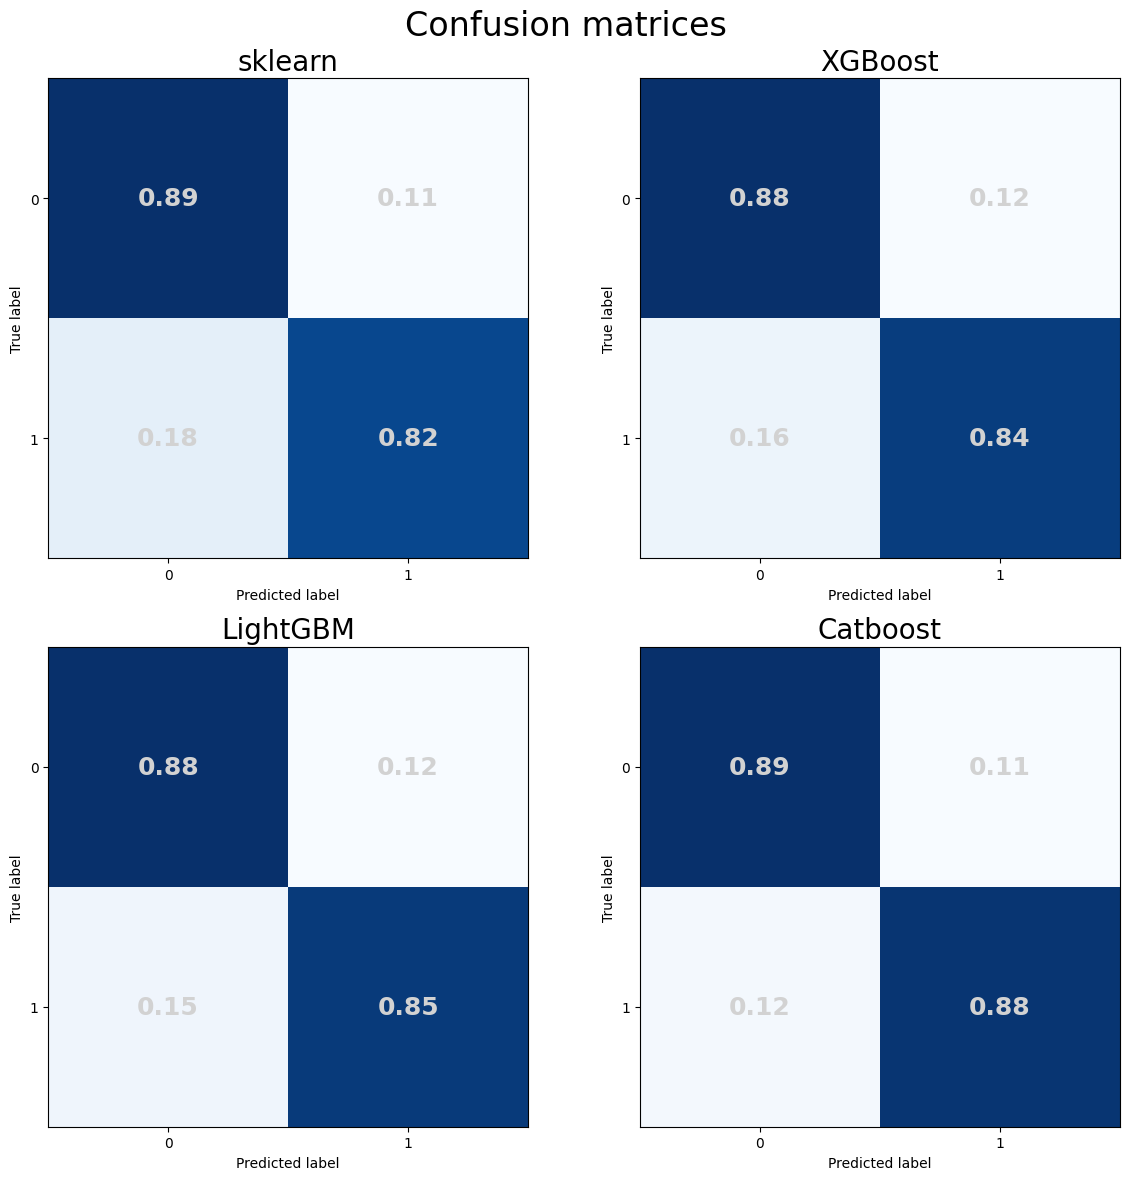

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)

fig, axs = plt.subplots(
    nrows=2, ncols=2,
    figsize=(12, 12),
    dpi=100
)

for model, title, ax in zip(
        [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
        ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
        axs.flatten()):
    # Fit the model on a subset of the data
    model.fit(X_train, y_train)

    # Show the confusion matrix on the test set
    cmatrix = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, ax=ax, cmap='Blues', colorbar=False,
        normalize='true',  # 'true' for rows, 'pred' for cols, 'all' for full matrix
        text_kw={'color': '#d2d2d2', 'fontweight': 'bold', 'size': '18'})
    ax.set_title(title, size=20)

fig.suptitle('Confusion matrices', size=24)
plt.tight_layout()
plt.show()

## ROC curve

The [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) shows the model's true-positive rate vs. false-positive rate for a binary classifier. The best model would have a true-positive rate of 1.0 at a false-positive rate of 0.0 (that is, 0 examples are misclassified). There is a tradeoff between TPR and FPR: if all samples are classified as positive, then the TRP is 1.0, but the FPR would also be high, since many examples would be falsely classified as positive. Coversely, if a model predicts all samples to be negative, the FPR will be 0, but the TPR would also be 0 (since no positive samples would be classified at all).

Reference:  
- [sklearn.metrics.RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.htm)

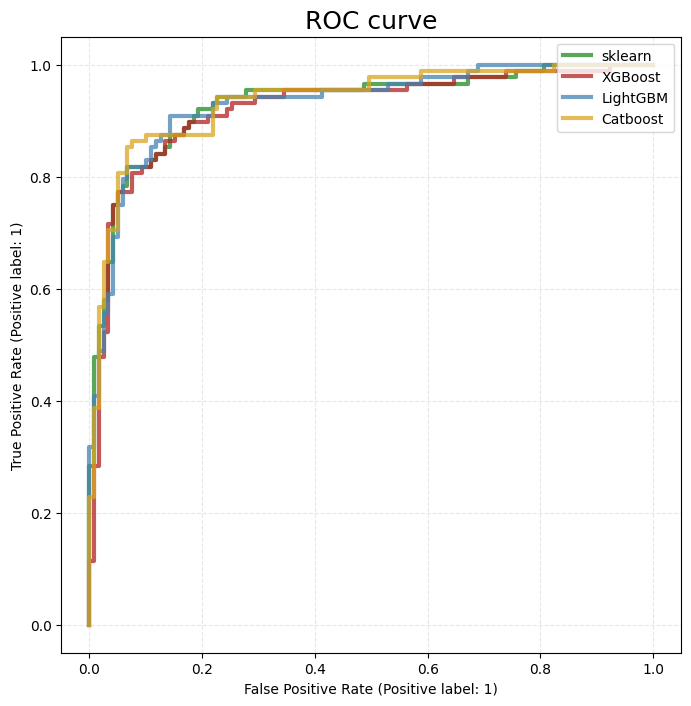

In [29]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

for model, title, color in zip(
        [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
        ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
        ['forestgreen', 'firebrick', 'steelblue', 'goldenrod']):
    # Fit the model on a subset of the data
    model.fit(X_train, y_train)

    # Show the confusion matrix on the test set
    roc_curve = RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=ax, color=color, label=title, alpha=0.75, lw=3)

plt.title('ROC curve', size=18)
plt.grid(alpha=0.3, ls='dashed')
plt.legend(loc='upper right')
plt.show()

## Precision-Recall curve

This curve shows the tradeoff between Precision (true predicted positives ÷ total predicted positives) and Recall (true predicted positives ÷ total positives). Note that the curve is calculated on the _test set_ of data but the models are trained on the _train dataset_.

Reference:  
- [sklearn.metrics.PrecisionRecallDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)

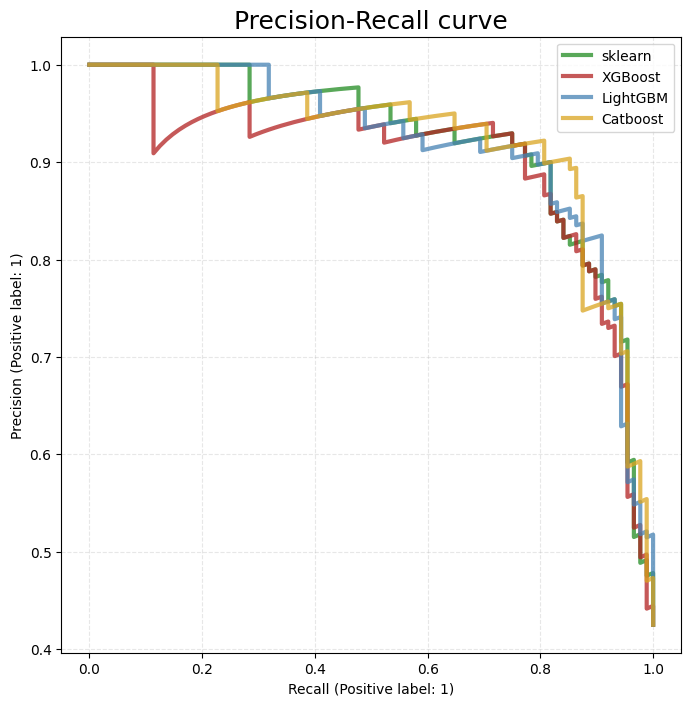

In [30]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)

for model, title, color in zip(
        [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
        ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
        ['forestgreen', 'firebrick', 'steelblue', 'goldenrod']):
    # Fit the model on a subset of the data
    model.fit(X_train, y_train)

    # Show the confusion matrix on the test set
    pr_curve = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, ax=ax, drawstyle='default',
        color=color, label=title, alpha=0.75, lw=3)

plt.title('Precision-Recall curve', size=18)
plt.grid(alpha=0.3, ls='dashed')
plt.legend(loc='upper right')
plt.show()

## Decision boundaries

Decision boundaries visualize the model's predictions (outputs) across two features, or dimensions.

**Reference:**  
- [sklearn.inspection.DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)

In [31]:
import copy

from sklearn.inspection import DecisionBoundaryDisplay

def show_boundaries(features: list, X: pd.DataFrame) -> None:
    ''' Plot the decision boundary for two features.

    # Parameters
    features: list
        The feature names (or column indices) of the features to plot.
        This should be a list of two feature names (or indices) to
        numerical features in the input dataset.
    X: `pandas.DataFrame`
        The full dataset, of which `features` are a subset.
    '''
    assert len(features) == 2, "'features' parameter can have only 2 values"

    if any([type(i) != str for i in features]):
        X_trimmed = X.iloc[:, features]
    else:
        X_trimmed = X[features]

    assert all(X_trimmed.columns.isin(X.select_dtypes(include='number'))), (
        "'features' must include numeric columns only. The numeric columns for "
        f"the dataset are: {X.select_dtypes(include='number').columns.tolist()}")

    fig, axs = plt.subplots(
        nrows=2, ncols=2,
        figsize=(8, 8),
        dpi=100
    )

    for model, title, ax in zip(
            [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
            ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
            axs.flatten()):
        # Fit the model on a subset of the data
        subset_model = copy.deepcopy(model[-1])
        if hasattr(subset_model, 'categorical_features'):
            # sklearn or LightGBM
            subset_model.categorical_features = None
        elif hasattr(subset_model, 'cat_features'):
            # Catboost
            subset_model.cat_features = None
        elif hasattr(subset_model, 'enable_categorical'):
            # XGBoost
            subset_model.enable_categorical = False
        subset_model.fit(X_trimmed, y)

        # Show the decision boundary for the given features
        db_display = DecisionBoundaryDisplay.from_estimator(
            subset_model, X_trimmed, ax=ax, plot_method='contourf',
            response_method='auto', alpha=0.5)
        ax.scatter(X_trimmed.iloc[:, 0], X_trimmed.iloc[:, 1], c=y,
                   edgecolor='black', alpha=0.7, lw=0.5)
        ax.set_title(title, size=14)

    fig.suptitle('Decision boundaries', size=18)
    plt.tight_layout()
    plt.show()

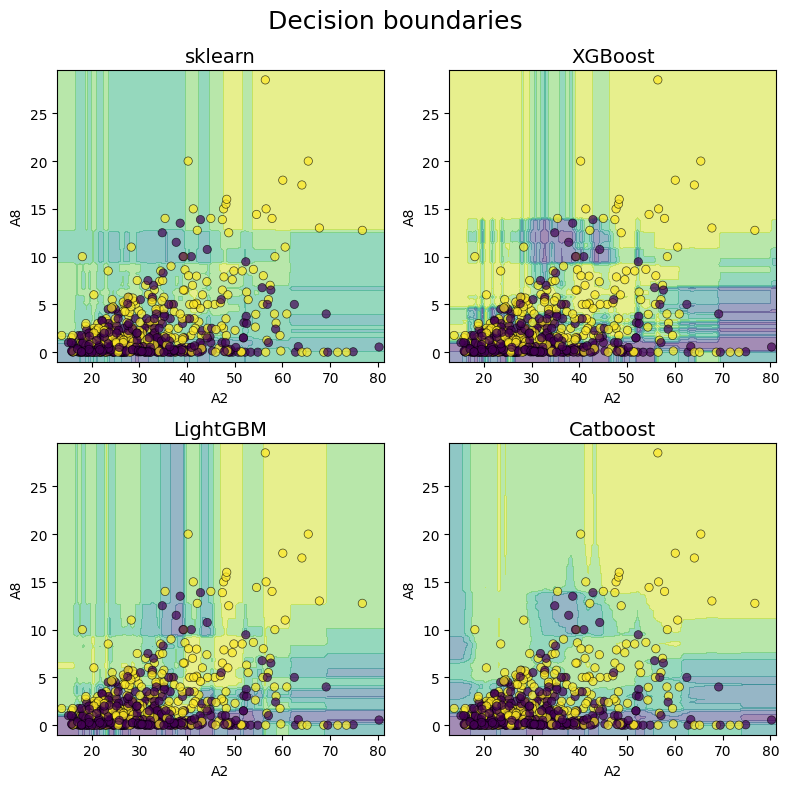

In [32]:
show_boundaries(features=['A2', 'A8'], X=X)

## `dtreeviz` tree visualizations

**Reference**
- [dtreeviz GitHub repo](https://github.com/parrt/dtreeviz/tree/master)
- [tree visualization examples](https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb)
- [decision boundary visualization examples](https://github.com/parrt/dtreeviz/blob/master/notebooks/classifier-decision-boundaries.ipynb)

In [33]:
%pip install --quiet dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.5 MB/s eta 0:00:00


In [34]:
import dtreeviz

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=12)


In [96]:
import copy

def show_boundaries(features: list, X: pd.DataFrame) -> None:
    ''' Plot the decision boundary for two features.

    # Parameters
    features: list
        The feature names (or column indices) of the features to plot.
        This should be a list of two feature names (or indices) to
        numerical features in the input dataset.
    X: `pandas.DataFrame`
        The full dataset, of which `features` are a subset.
    '''
    assert len(features) == 2, "'features' parameter can have only 2 values"

    if any([type(i) != str for i in features]):
        X_trimmed = X.iloc[:, features]
    else:
        X_trimmed = X[features]

    assert all(X_trimmed.columns.isin(X.select_dtypes(include='number'))), (
        "'features' must include numeric columns only. The numeric columns for "
        f"the dataset are: {X.select_dtypes(include='number').columns.tolist()}")

    fig, axs = plt.subplots(
        nrows=2, ncols=2,
        figsize=(16, 8),
        dpi=100
    )

    for model, title, ax in zip(
            [gbm_sklearn, gbm_xgb, gbm_lgb, gbm_cb],
            ['sklearn', 'XGBoost', 'LightGBM', 'Catboost'],
            axs.flatten()):
        # Fit the model on a subset of the data
        subset_model = copy.deepcopy(model[-1])
        if hasattr(subset_model, 'categorical_features'):
            # sklearn or LightGBM
            subset_model.categorical_features = None
        elif hasattr(subset_model, 'cat_features'):
            # Catboost
            subset_model.cat_features = None
        elif hasattr(subset_model, 'enable_categorical'):
            # XGBoost
            subset_model.enable_categorical = False

        # Convert to NumPy because dtreeviz will do that anyways, which removes
        # feature names. Also convert target (y) to int.
        subset_model.fit(X_trimmed.to_numpy(), y.astype(int))

        # Show the decision boundary for the given features
        d_boundaries = dtreeviz.decision_boundaries(
            model=subset_model,
            X=X_trimmed,
            y=y.astype(int),
            ax=ax,
            feature_names=X_trimmed.columns,
            target_name='target',
            class_names=['denied', 'approved'],
            fontname=None,
            # show=['instances', 'boundaries', 'misclassified'],
            tile_fraction=1.0,
            colors={'scatter_marker_alpha': 0.5})
        ax.set_title(title, size=14)

    fig.suptitle('Decision boundaries', size=18)
    plt.tight_layout()
    plt.show()

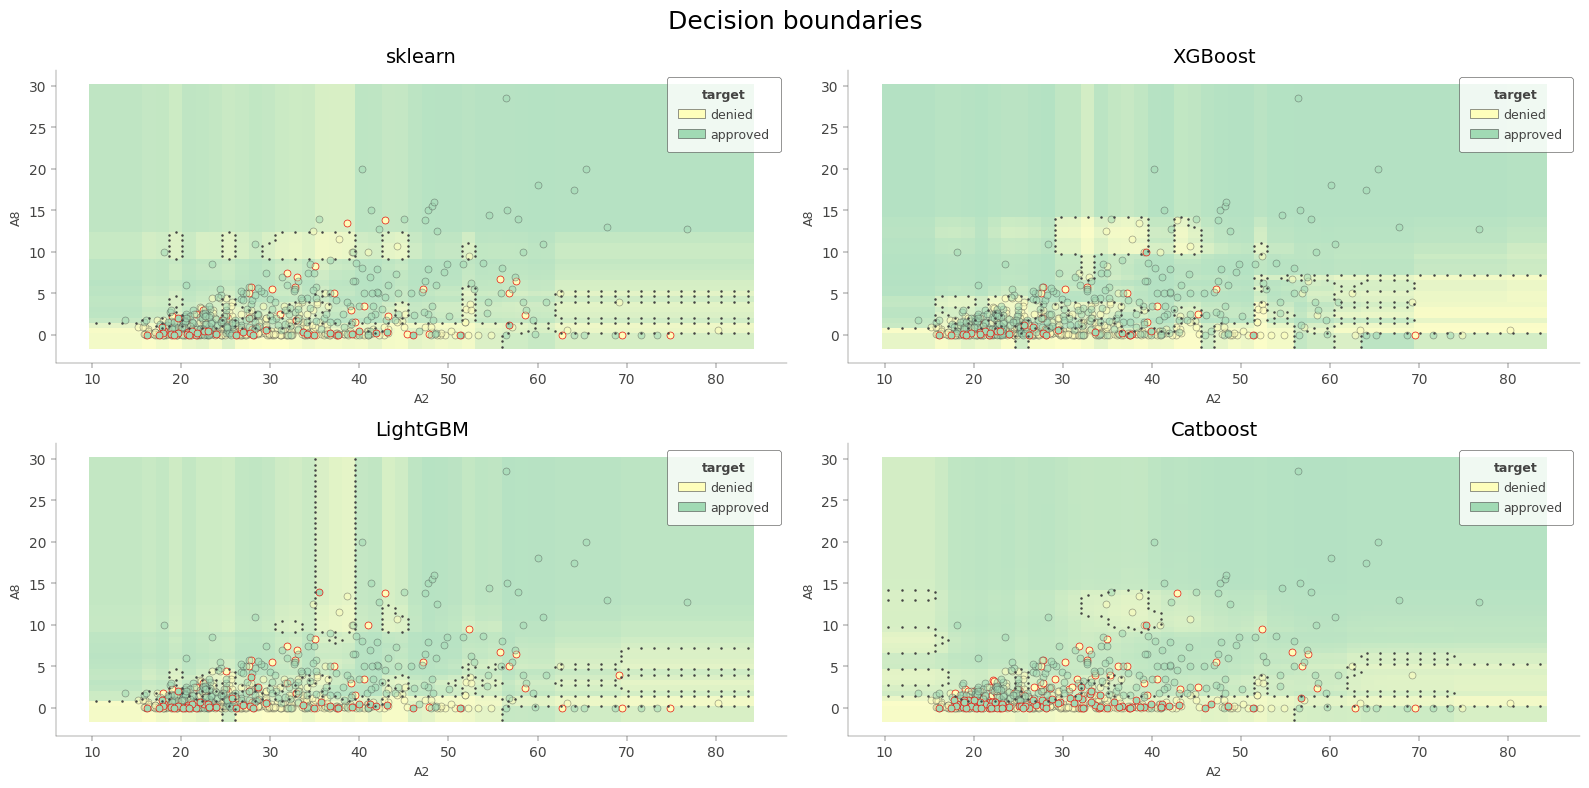

In [97]:
show_boundaries(features=['A2', 'A8'], X=X)

## Other plots

Other plots to try include:
- [sklearn.calibration.CalibrationDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html)
- [sklearn.model_selection.LearningCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LearningCurveDisplay.html)
- Any others of interest among those provided by [sklearn](https://scikit-learn.org/stable/visualizations.html), [dtreeviz](https://github.com/parrt/dtreeviz), or the models' individual plotting methods

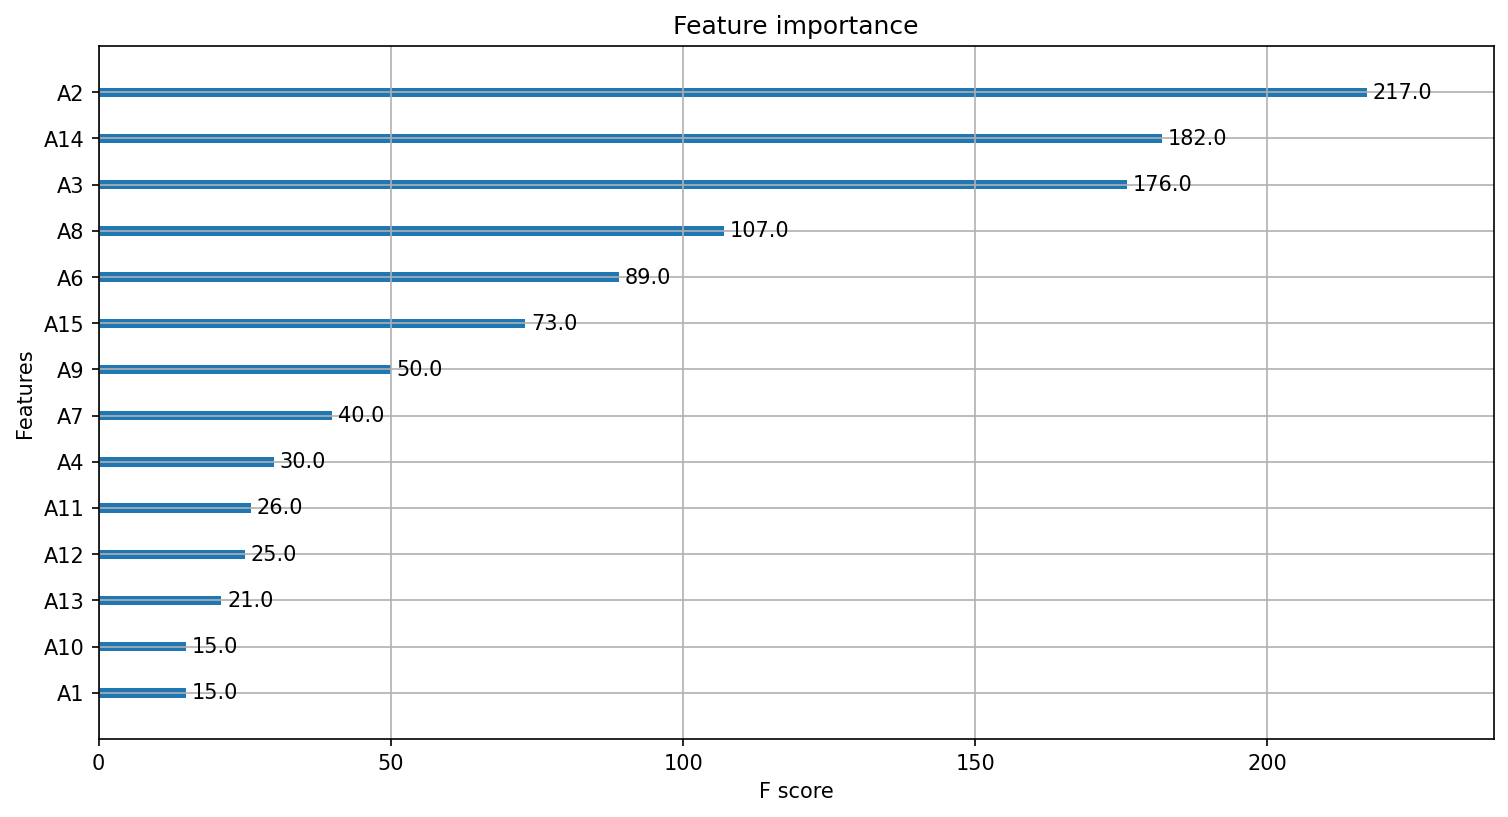

In [106]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
xgb.plot_importance(gbm_xgb[-1], ax=ax)
plt.show()

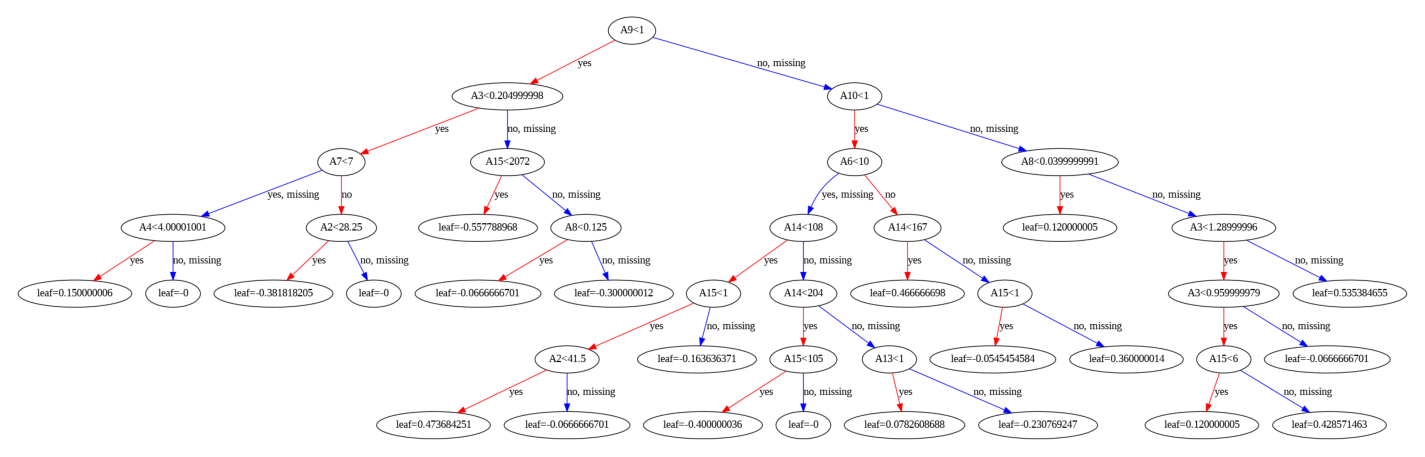

In [105]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)
xgb.plot_tree(gbm_xgb[-1], ax=ax)
plt.show()

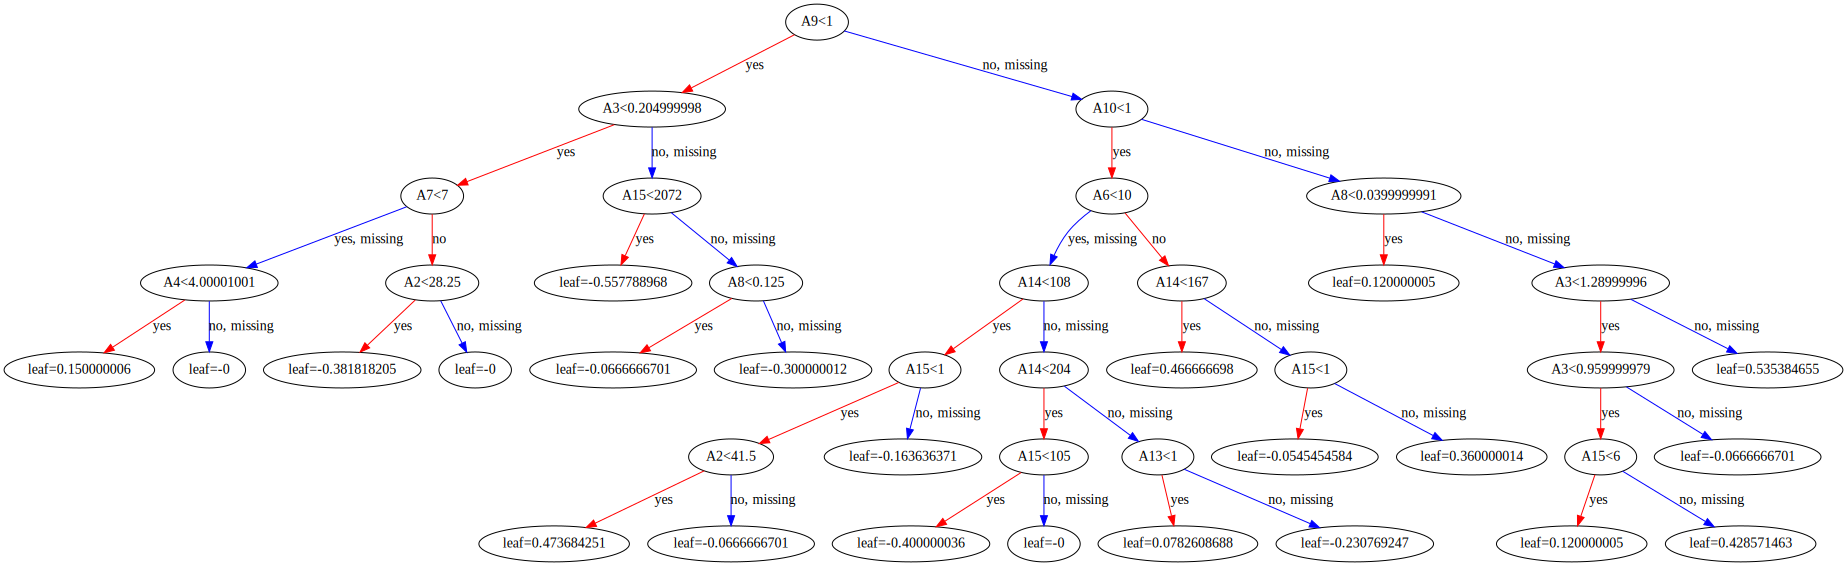

In [102]:
xgb.to_graphviz(gbm_xgb[-1])

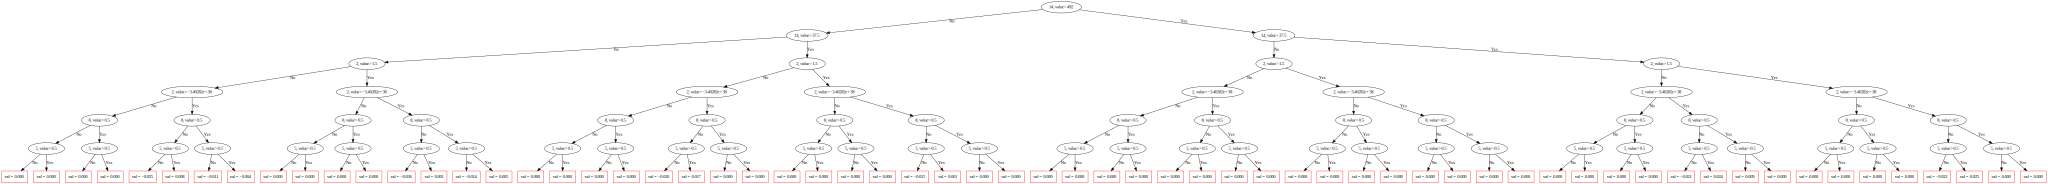

In [107]:
gbm_cb[-1].plot_tree(0)